# SHO Fitter Inference Results Visualization

In [4]:
import sys
sys.path.append('../../')

In [5]:
%load_ext autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import time
import pandas as pd
import pyUSID as usid
import os

import torch
import torch.nn as nn

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler

import numpy.lib.recfunctions as rfn

from pyUSID.io import Dimension

from IPython.display import clear_output

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

from src.m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from src.m3_learning.be.processing import convert_amp_phase, transform_params, SHO_fit_to_array
from src.m3_learning.util.preprocessing import global_scaler
from src.m3_learning.viz.printing import printer
from src.m3_learning.viz.layout import combine_lines, labelfigs


printing = printer(basepath='./figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'm3_learning'

## Loads data

In [ ]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

num_pix_1d = int(np.sqrt(num_pix))

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# extracting spectroscopic values
spectroscopic_values = h5_f['Measurement_000']['Channel_000']['Spectroscopic_Values']

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

In [ ]:
# create a list for parameters
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

In [ ]:
# create a list for parameters
pred_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-Predictions_000"]["SHO_Pred_Results"], channels = 4)

# exclude the R2 parameter
all_pred_params = pred_results_list.reshape(-1, 4)

all_pred_params_scaled = params_scaler.transform(all_pred_params.copy())

### Visualize 10 outlier results (resonance frequency < 1.31 MHz)

In [3]:
data_real = np.copy(scaled_data_real)
data_imag = np.copy(scaled_data_imag)

data_real = scaler_real.inverse_transform(data_real)
data_imag = scaler_imag.inverse_transform(data_imag)

out_sho_nn = SHO_fit_func_torch(torch.tensor(
                              all_pred_params[:]), wvec_freq)
out_sho_lsqf = SHO_fit_func_torch(torch.tensor(
                              params[:]), wvec_freq)

magnitude_graph_initial, phase_graph_initial = convert_amp_phase(raw_data_resampled)
magnitude_graph_nn, phase_graph_nn = convert_amp_phase(out_sho_nn)
magnitude_graph_lsqf, phase_graph_lsqf = convert_amp_phase(out_sho_lsqf)

indices_res = np.where((params[:, 1] < 1.31 * 1e6))

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

fig.suptitle('10 examples with resonance frequency < 1.31 MHz', fontsize=20)

for y in range(5):
  for x in range(2):
    i = np.random.randint(0, len(indices_res[0]))
    i = indices_res[0][i]
    axs[x, y].plot(wvec_freq, magnitude_graph_nn[i], '--', color='blue', label='NN magnitude')
    axs[x, y].plot(wvec_freq, magnitude_graph_lsqf[i], color='blue', label='LSQF magnitude')
    axs[x, y].plot(wvec_freq, magnitude_graph_initial[i], 'o', color='blue', label='Raw Data magnitude')
    axs[x, y].set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')
    ax2 = axs[x, y].twinx()
    ax2.plot(wvec_freq, phase_graph_nn[i], '--', color='red', label='NN phase')
    ax2.plot(wvec_freq, phase_graph_lsqf[i], color='red', label='LSQF phase')
    ax2.plot(wvec_freq, phase_graph_initial[i], 'o', color='red', label='Raw Data phase')

    axs[x, y].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax2.set(xlabel='Frequency (Hz)', ylabel='Phase (rad)');

    if x == 0 and y == 0:
      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(l, []) for l in zip(*lines_labels)]

fig.tight_layout()
plt.legend(lines, labels, bbox_to_anchor=(1.05, 2.7), loc='upper right', borderaxespad=0., prop={'size': 14})
fig.subplots_adjust(top=0.87)

printing.savefig(fig, "Figure_11_examples_with_outlier_resonance_frequency.png", tight_layout=False)


NameError: name 'np' is not defined

### Visualize of best/medium/worst results

In [12]:
mse_sho_nn = (np.mean(np.square(scaled_data_real - scaler_real.transform(np.array(torch.real(out_sho_nn)))), 1) + np.mean(np.square(scaled_data_imag - scaler_imag.transform(np.array(torch.imag(out_sho_nn)))), 1)) / 2.0
mse_sho_lsqf = (np.mean(np.square(scaled_data_real - scaler_real.transform(np.array(torch.real(out_sho_lsqf)))), 1) + np.mean(np.square(scaled_data_imag - scaler_imag.transform(np.array(torch.imag(out_sho_lsqf)))), 1)) / 2.0
highest_sho_nn = (-mse_sho_nn).argsort()[:]
highest_sho_lsqf = (-mse_sho_lsqf).argsort()[:]
print('MSE of SHO with NN: ' + str(np.mean(mse_sho_nn)))
print('MSE of SHO with LSQF: ' + str(np.mean(mse_sho_lsqf)))

MSE of SHO with NN: 0.04220614569223912
MSE of SHO with LSQF: 0.04375120613269597


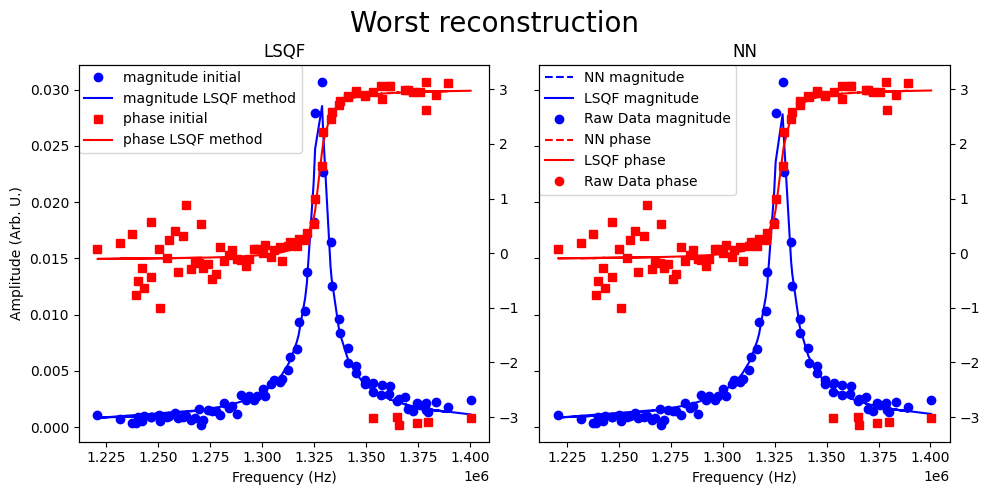

./figures/Figure_12_Worst_reconstruction.png.png
./figures/Figure_12_Worst_reconstruction.png.svg


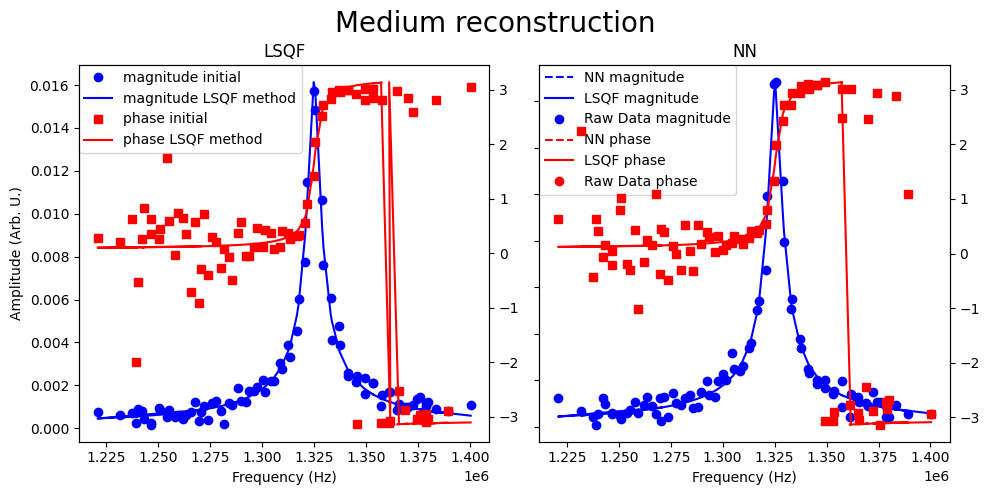

./figures/Figure_13_Medium_reconstruction.png.png
./figures/Figure_13_Medium_reconstruction.png.svg


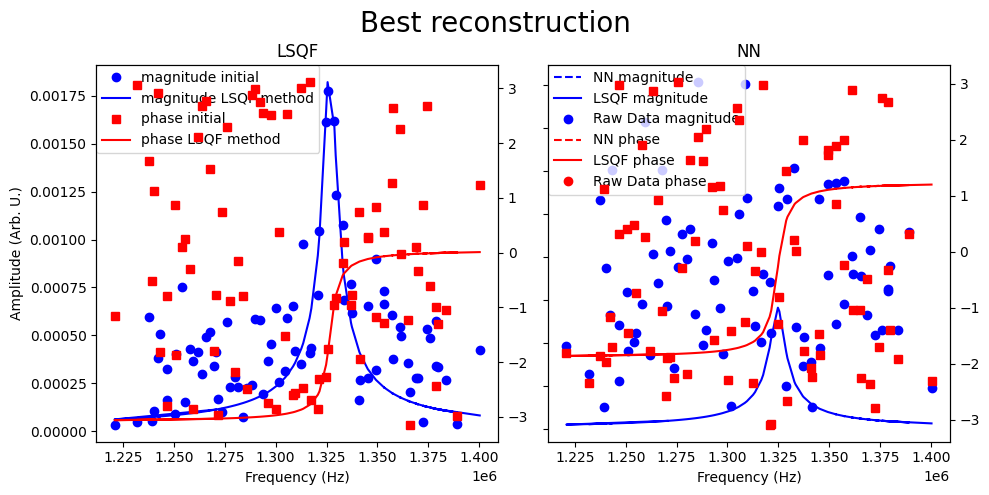

./figures/Figure_14_Best_reconstruction.png.png
./figures/Figure_14_Best_reconstruction.png.svg


In [13]:
graph_num = [0, data_real.shape[0] // 2, -1]
names = ['Worst', 'Medium', 'Best']

for iters, j in enumerate(range(len(graph_num))):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(names[j] + ' reconstruction', fontsize=20)

    i = graph_num[j]

    out_sho_lsqf_1d = SHO_fit_func_torch(torch.tensor(np.atleast_2d(params[highest_sho_lsqf[i]])), wvec_freq)
    magnitude_graph_lsqf, phase_graph_lsqf = convert_amp_phase(out_sho_lsqf_1d)

    out_sho_nn_1d = SHO_fit_func_torch(torch.tensor(np.atleast_2d(all_pred_params[highest_sho_nn[i]])), wvec_freq)
    magnitude_graph_nn, phase_graph_nn = convert_amp_phase(out_sho_nn_1d)

    axs[0].set_title('LSQF')
    axs[0].plot(wvec_freq, magnitude_graph_initial[highest_sho_lsqf[i], :], 'o', label='magnitude initial', color='b')
    axs[0].plot(wvec_freq, magnitude_graph_lsqf[0, :], label='magnitude LSQF method', color='b')
    ax1 = axs[0].twinx()
    ax1.plot(wvec_freq, phase_graph_initial[highest_sho_lsqf[i], :], 's', label='phase initial', color='r')
    ax1.plot(wvec_freq, phase_graph_lsqf[0, :], label='phase LSQF method', color='r')

    axs[1].set_title('NN')
    axs[1].plot(wvec_freq, magnitude_graph_initial[highest_sho_nn[i], :], 'o', label='magnitude initial', color='b')
    axs[1].plot(wvec_freq, magnitude_graph_nn[0, :], label='magnitude NN', color='b')
    ax2 = axs[1].twinx()
    ax2.plot(wvec_freq, phase_graph_initial[highest_sho_nn[i], :], 's', label='phase initial', color='r')
    ax2.plot(wvec_freq, phase_graph_nn[0, :], label='phase NN', color='r')

    for ax in axs.flat:
        ax.set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')

    for ax in axs.flat:
        ax.label_outer()
        
    lines0, labels0 = combine_lines(axs[0], ax1)
    lines1, labels1 = combine_lines(axs[1], ax2)

    plt.tight_layout()
    axs[1].legend(lines, labels, bbox_to_anchor=(0, 1.00), loc='upper left', borderaxespad=0.)
    axs[0].legend(lines0, labels0, bbox_to_anchor=(0, 1.00), loc='upper left', borderaxespad=0.)

    fig.subplots_adjust(top=0.87)
    plt.show()    

    printing.savefig(fig, f"Figure_{iters+12}_{names[j]}_reconstruction.png")

### Visualize distribution of parameters using violin plots

In [14]:
df_to_plot = pd.DataFrame(np.vstack((all_pred_params_scaled, scaled_params)))
df_to_plot = df_to_plot.melt(var_name='Params', value_name='Normalized Params')
df_to_plot['Fit Type'] = 'LSQF'

for i in range(0,8,2):
  df_to_plot.loc[i*all_pred_params_scaled.shape[0]:(i+1)*all_pred_params_scaled.shape[0], 'Fit Type'] = 'NN'

./figures/Figure_15_SHO_fit_Violin.png.png
./figures/Figure_15_SHO_fit_Violin.png.svg


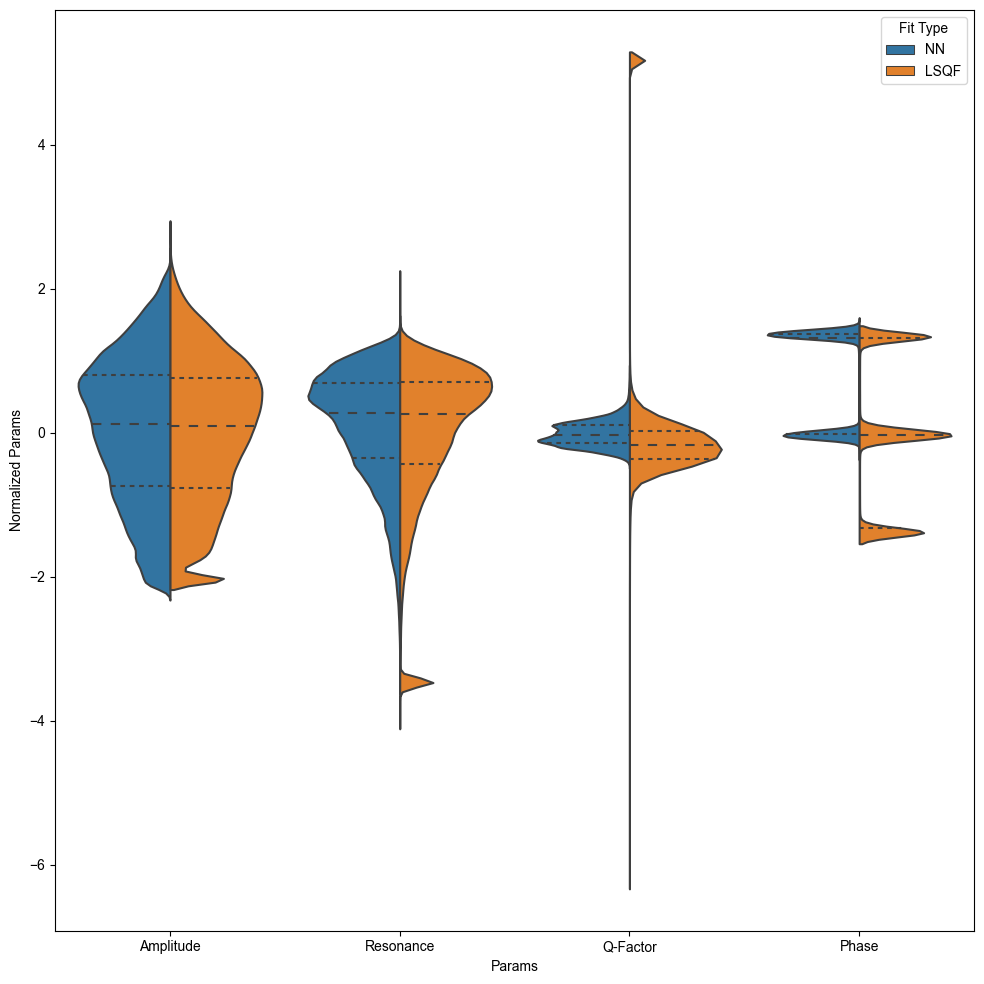

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

sns.violinplot(x='Params', y='Normalized Params', hue='Fit Type', data=df_to_plot, ax=axs, scale='count', split=True, inner='quartile')
axs.set_xticklabels(labels);
sns.set_theme(style='whitegrid')

printing.savefig(fig, f"Figure_15_SHO_fit_Violin.png")

### Movies per timestep visualization

In [16]:
all_params_transformed, all_pred_params_transformed = transform_params(params.copy(), all_pred_params.copy())

nn_maps = all_pred_params_transformed[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]
lsqf_maps = all_params_transformed[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]

In [17]:
sns.reset_orig()
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [18]:



if os.path.exists("./Assets/Maps/Waveform"):
    pass
else:
    os.makedirs("Assets/Maps/Waveform")

if os.path.exists("./Assets/Maps/Compared"):
    pass
else:
    os.makedirs("Assets/Maps/Compared")

In [19]:
# plt.ion()

In [23]:
for voltage_step in range(0, nn_maps.shape[0], 12):
    if(voltage_step>96):
      break
    img_index = voltage_step // 12
    for param in range(4):
        fig1 = plt.figure()
        im1 = plt.imshow(nn_maps[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d))
        plt.colorbar(im1, format='%.2e')
        plt.axis('off')
        plt.savefig('./Assets/Maps/Waveform/map_nn_' + str(param) + '_' + str(img_index) + '.png', bbox_inches='tight', pad_inches=0)
        plt.close(fig1)
        fig2 = plt.figure()
        im2 = plt.imshow(lsqf_maps[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d))
        plt.colorbar(im2, format='%.2e')
        plt.axis('off')
        plt.savefig('./Assets/Maps/Waveform/map_lsqf_' + str(param) + '_' + str(img_index) + '.png', bbox_inches='tight', pad_inches=0)
        plt.close(fig2)
        clear_output(wait=True)

In [25]:
for voltage_step in range(0, nn_maps.shape[0], 12):
    if(voltage_step>96):
      break
    
    
    fig = plt.figure(figsize=(8., 2.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                      nrows_ncols=(2, 4))
    
    img_index = voltage_step // 12
    imgs = []
    for param in range(4):
      imgs.append(mpimg.imread('./Assets/Maps/Waveform/map_nn_' + str(param) + '_' + str(img_index) + '.png'))
      imgs.append(mpimg.imread('./Assets/Maps/Waveform/map_lsqf_' + str(param) + '_' + str(img_index) + '.png'))

    for i in range(0, 8, 2):
      grid[i//2].imshow(imgs[i])
      grid[i//2].axis('off')

    for i in range(1, 9, 2):
      grid[i//2+4].imshow(imgs[i])
      grid[i//2+4].axis('off')
    
    plt.savefig('./Assets/Maps/Compared/map_voltage_step_' + str(voltage_step), bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    clear_output(wait=True)

In [26]:

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30, 10))
axs.plot(spectroscopic_values[1, ::165][192::2] * spectroscopic_values[2, ::165][192::2])
markers = ['o', 'v', '^', '>', '<', 's', 'P', 'D', '*']

for voltage_step in range(0, nn_maps.shape[0], 12):
    if(voltage_step>96):
        break
    img_index = voltage_step // 12
    if(voltage_step==96):
        voltage_step -= 1
    xy = (voltage_step, (spectroscopic_values[1, ::165][192::2] * spectroscopic_values[2, ::165][192::2])[voltage_step])

    axs.plot(xy[0], xy[1], markers[img_index], markersize=20, color='black')

plt.savefig('Assets/Figures/maps_waveform_1.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/maps_waveform_1.svg', bbox_inches='tight', pad_inches=1)
# plt.figure()
# plt.close(fig)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 10))
axs[0, 0].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_0.png'))
axs[0, 0].set_title('●', fontsize=20)
axs[0, 1].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_12.png'))
axs[0, 1].set_title('▼', fontsize=20)
axs[0, 2].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_24.png'))
axs[0, 2].set_title('▲', fontsize=20)
axs[1, 0].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_36.png'))
axs[1, 0].set_title('▶', fontsize=20)
axs[1, 1].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_48.png'))
axs[1, 1].set_title('◀', fontsize=20)
axs[1, 2].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_60.png'))
axs[1, 2].set_title('◼', fontsize=20)
axs[2, 0].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_72.png'))
axs[2, 0].set_title('+', fontsize=20)
axs[2, 1].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_84.png'))
axs[2, 1].set_title('◆', fontsize=20)
axs[2, 2].imshow(mpimg.imread('./Assets/Maps/Compared/map_voltage_step_96.png'))
axs[2, 2].set_title('*', fontsize=20)

plt.savefig('Assets/Figures/maps_waveform_2.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/maps_waveform_2.svg', bbox_inches='tight', pad_inches=1)

plt.tight_layout()

In [27]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30, 10))

axs.plot(spectroscopic_values[1, ::165][192::2] * spectroscopic_values[2, ::165][192::2])

for voltage_step in range(0, nn_maps.shape[0], 12):
  if(voltage_step>96):
    break
  img_index = voltage_step // 12
  imgs = []
  for param in range(4):
    imgs.append(mpimg.imread('./Assets/Maps/Waveform/map_nn_' + str(param) + '_' + str(img_index) + '.png'))
    imgs.append(mpimg.imread('./Assets/Maps/Waveform/map_lsqf_' + str(param) + '_' + str(img_index) + '.png'))

  for i in range(0, 8, 2):
    x = 0
    y = 0
    if(voltage_step == 96):
      x = -2
    if(voltage_step == 72):
      y = 3
    imagebox_nn = OffsetImage(imgs[i], zoom=0.2)
    imagebox_lsqf = OffsetImage(imgs[i+1], zoom=0.2)
    ab_nn = AnnotationBbox(imagebox_nn, (voltage_step - 2 + i + x, (spectroscopic_values[1, ::165][192::2] * spectroscopic_values[2, ::165][192::2])[voltage_step-1]+y))
    ab_lsqf = AnnotationBbox(imagebox_lsqf, (voltage_step - 2 + i + x, (spectroscopic_values[1, ::165][192::2] * spectroscopic_values[2, ::165][192::2])[voltage_step-1]-3+y))
    axs.add_artist(ab_nn)
    axs.add_artist(ab_lsqf)

    plt.grid()
    plt.draw()

plt.savefig('Assets/Figures/maps_waveform.png')
plt.savefig('Assets/Figures/maps_waveform.svg')

In [ ]:
h5_f.close()